I split this on the cases and then decided to work on the code for each case separately.

data <- c(1.64, 1.70, 1.72, 1.74, 1.82, 1.82, 1.82, 1.90, 2.08)

# Case 1

In [3]:
likelihood <- function(theta, sigma2) {
  n <- length(data)
  sum(log(dnorm(data, mean = theta, sd = sqrt(sigma2))))
}

In [4]:
prior_theta <- function(theta, mu0, tau20) {
  dnorm(theta, mean = mu0, sd = sqrt(tau20))
}

In [5]:
prior_sigma2 <- function(sigma2, nu0, sigma20) {
  dgamma(1/sigma2, shape = nu0/2, rate = (nu0/2)*sigma20)
}

In [6]:
gibbs_sampler_case1 <- function(n_iterations, mu0, tau20, nu0, sigma20) {
  theta <- numeric(n_iterations)
  sigma2 <- numeric(n_iterations)
  theta[1] <- mean(data)
  sigma2[1] <- var(data)
  
  for (i in 2:n_iterations) {
    # Sample theta from the posterior conditional distribution
    tau2 <- 1 / (1/tau20 + length(data)/sigma2[i-1])
    mu <- tau2 * (mu0/tau20 + sum(data)/sigma2[i-1])
    theta[i] <- rnorm(1, mean = mu, sd = sqrt(tau2))
    
    # Sample sigma2 from the posterior conditional distribution
    shape <- nu0/2 + length(data)/2
    rate <- nu0*sigma20/2 + sum((data - theta[i])^2)/2
    sigma2[i] <- 1 / rgamma(1, shape = shape, rate = rate)
  }
  
  list(theta = theta, sigma2 = sigma2)
}

In [7]:
n_iterations <- 5000
samples_case1 <- gibbs_sampler_case1(n_iterations, mu0 = 1.9, tau20 = 0.95, nu0 = 1, sigma20 = 0.01)

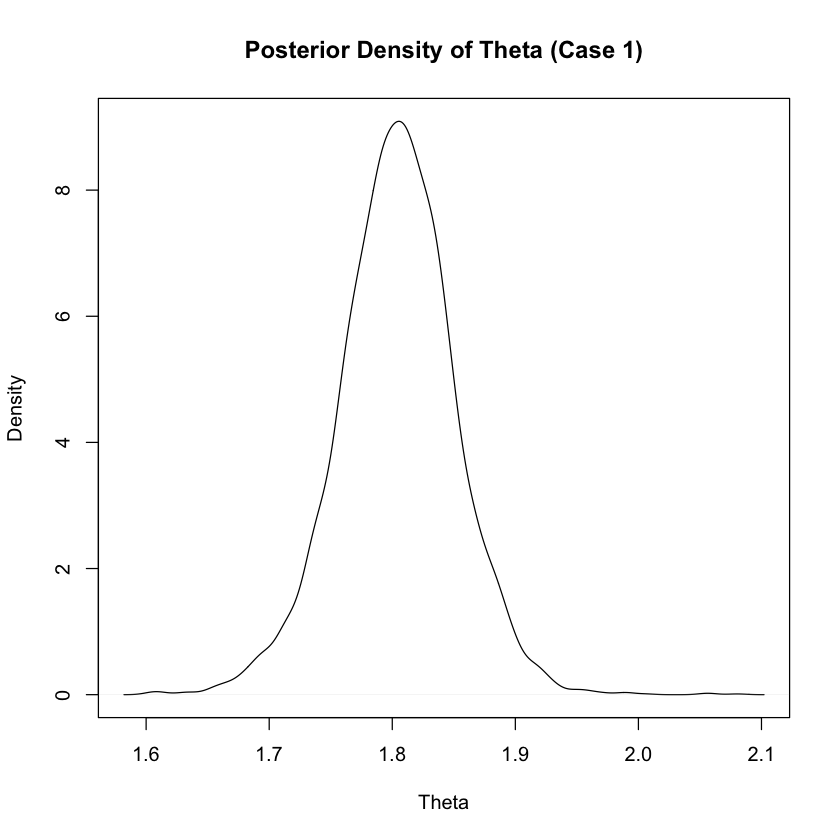

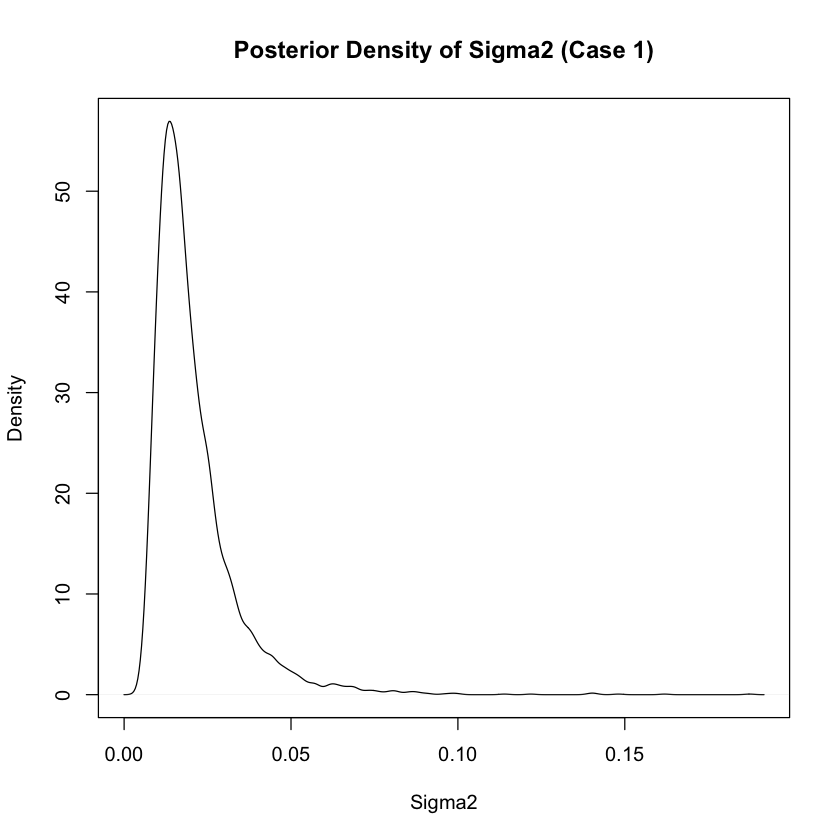

In [10]:
#install.packages("coda")
library(coda)  # For MCMC diagnostics

# Plot posterior densities
dens_plot_case1 <- density(samples_case1$theta)
plot(dens_plot_case1, main = "Posterior Density of Theta (Case 1)", xlab = "Theta")

dens_plot_case1_sigma2 <- density(samples_case1$sigma2)
plot(dens_plot_case1_sigma2, main = "Posterior Density of Sigma2 (Case 1)", xlab = "Sigma2")

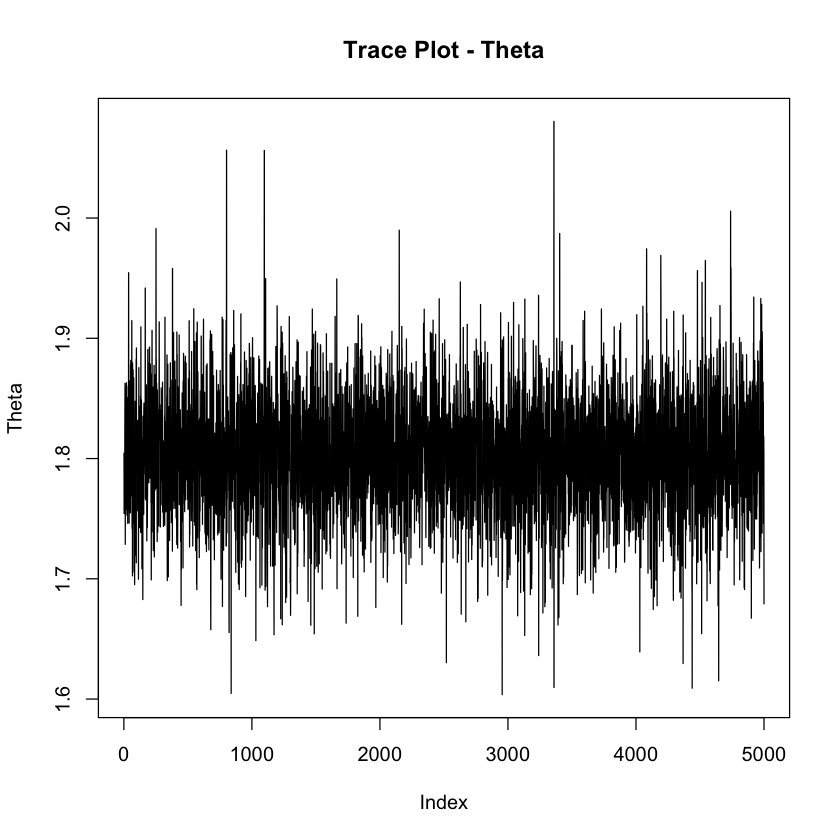

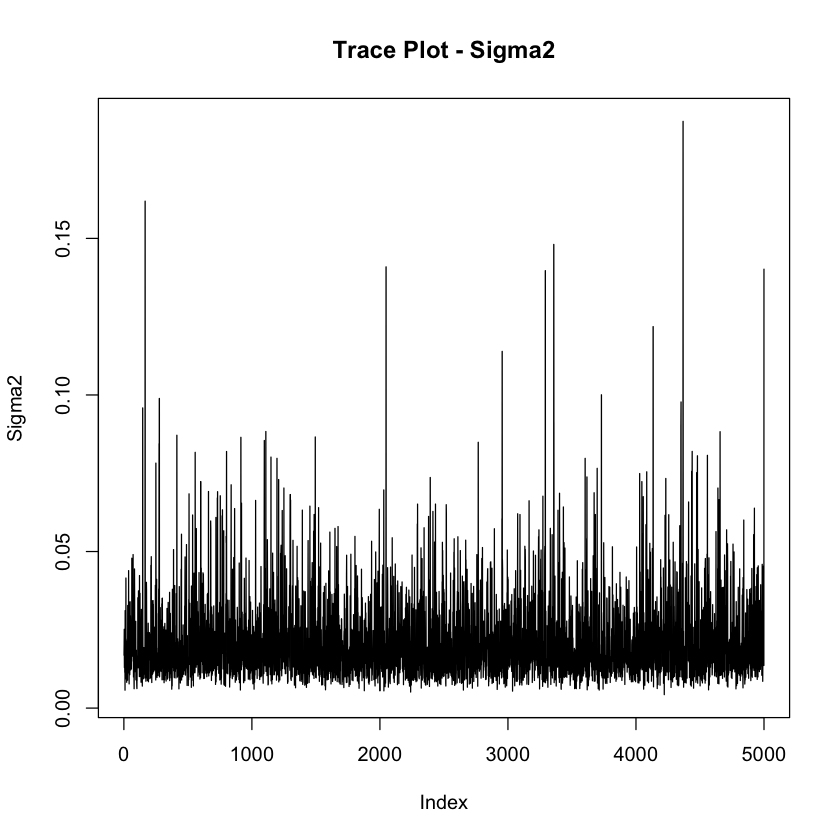

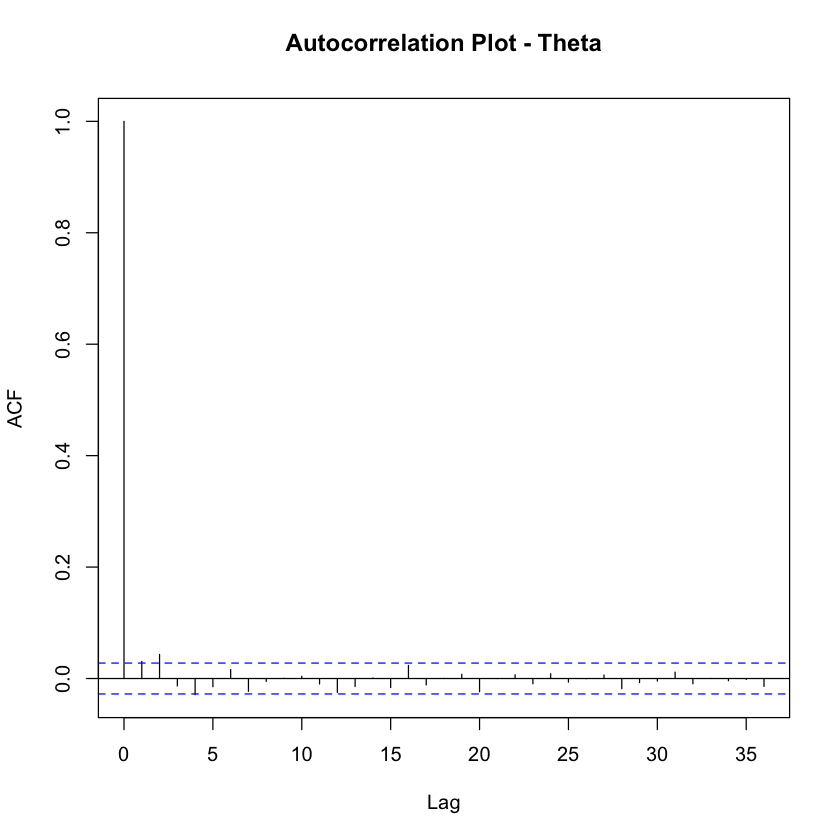

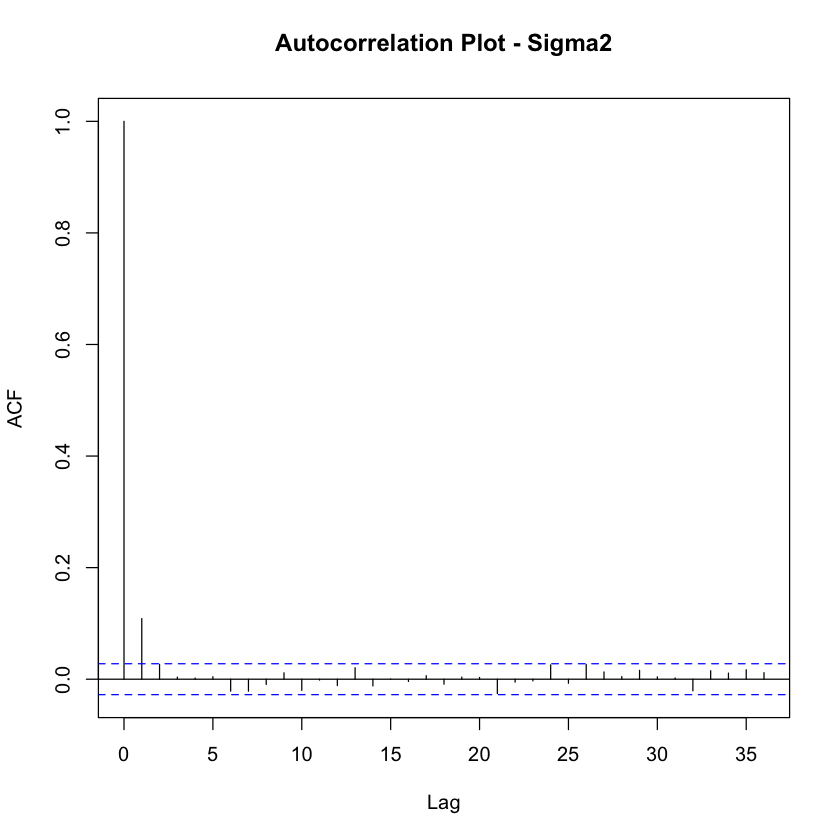

In [14]:
# Extract the chains from the samples
chain_theta <- samples_case1$theta
chain_sigma2 <- samples_case1$sigma2

# Trace plot
plot(chain_theta, type = "l", main = "Trace Plot - Theta", ylab = "Theta")
plot(chain_sigma2, type = "l", main = "Trace Plot - Sigma2", ylab = "Sigma2")

# Autocorrelation plot
acf(chain_theta, main = "Autocorrelation Plot - Theta")
acf(chain_sigma2, main = "Autocorrelation Plot - Sigma2")


# Case 2

In [32]:
prior_sigma20 <- function(sigma20, a, beta) {
  (beta^a / gamma(a)) * (sigma20^(a-1)) * exp(-beta*sigma20)
}

In [33]:
prior_theta <- function(theta, mu0, tau02) {
  1 / sqrt(2*pi*tau02) * exp(-((theta - mu0)^2) / (2*tau02))
}


In [34]:
likelihood <- function(theta, sigma2) {
  sum(log(1 / sqrt(2*pi*sigma2) * exp(-((data - theta)^2) / (2*sigma2))))
}


In [35]:
gibbs_sampler_case2 <- function(n_iterations, mu0, tau02, nu0, a1, a2, a3, beta) {
  theta <- numeric(n_iterations)
  sigma20 <- numeric(n_iterations)
  beta_samples <- numeric(n_iterations)
  
  # Initialize theta, sigma20, beta
  theta[1] <- mean(data)
  sigma20[1] <- var(data)
  beta_samples[1] <- 0.01
  
  for (i in 2:n_iterations) {
    # Sample theta from the posterior conditional distribution
    sigma2 <- 1 / sigma20[i-1]
    precision <- nu0/2 + length(data)/2
    mean_theta <- (nu0/2 * sigma20[i-1] + sum(data)) / precision
    theta[i] <- rnorm(1, mean = mean_theta, sd = sqrt(1/precision))
    
    # Sample sigma20 from the posterior conditional distribution
    a <- nu0/2 + length(data)/2
    b <- nu0/2 * sigma20[i-1] + sum((data - theta[i])^2)/2
    sigma20[i] <- 1 / rgamma(1, shape = a, rate = b)
    
    # Sample beta from the posterior conditional distribution
    a1 <- a1 * beta
    a2 <- a2 * beta
    a3 <- a3 * beta
    beta <- rbeta(1, shape1 = a1, shape2 = a2 + a3)
    beta_samples[i] <- beta
  }
  
  return(list(theta = theta, sigma20 = sigma20, beta = beta_samples))
}



Making this with setting a --> 0.1, 1, 10 for comparison

In [49]:
# Step 4: Run the Gibbs Sampler
n_iterations <- 5000
samples_case2 <- gibbs_sampler_case2(n_iterations, mu0 = 1.9, tau02 = 0.95, nu0 = 1, a1 = 0.01, a2 = 1, a3 = 10, beta = 0.01)

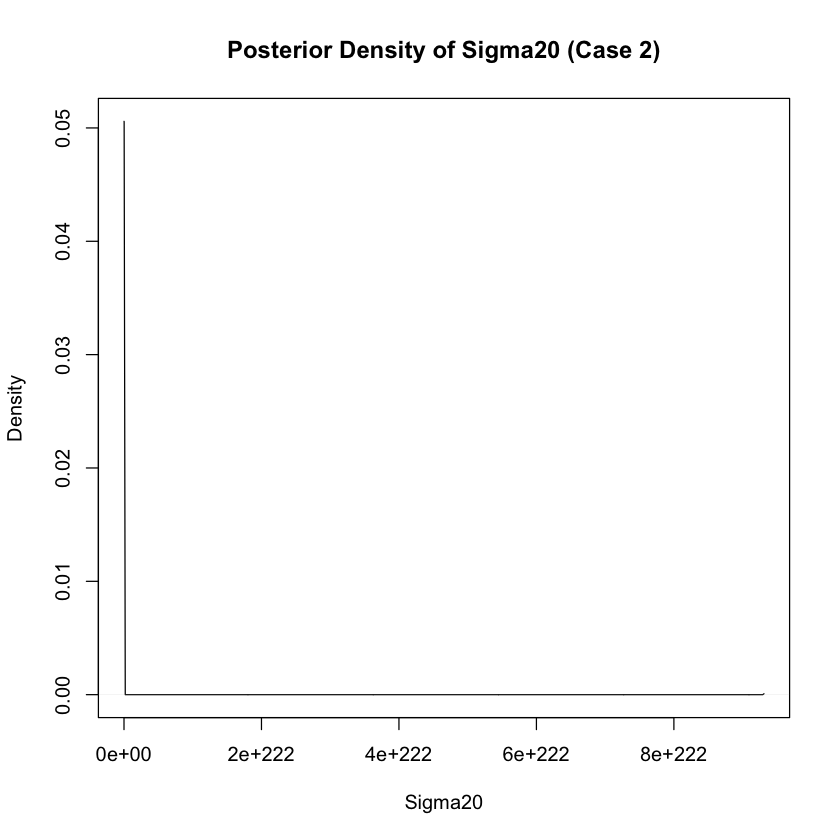

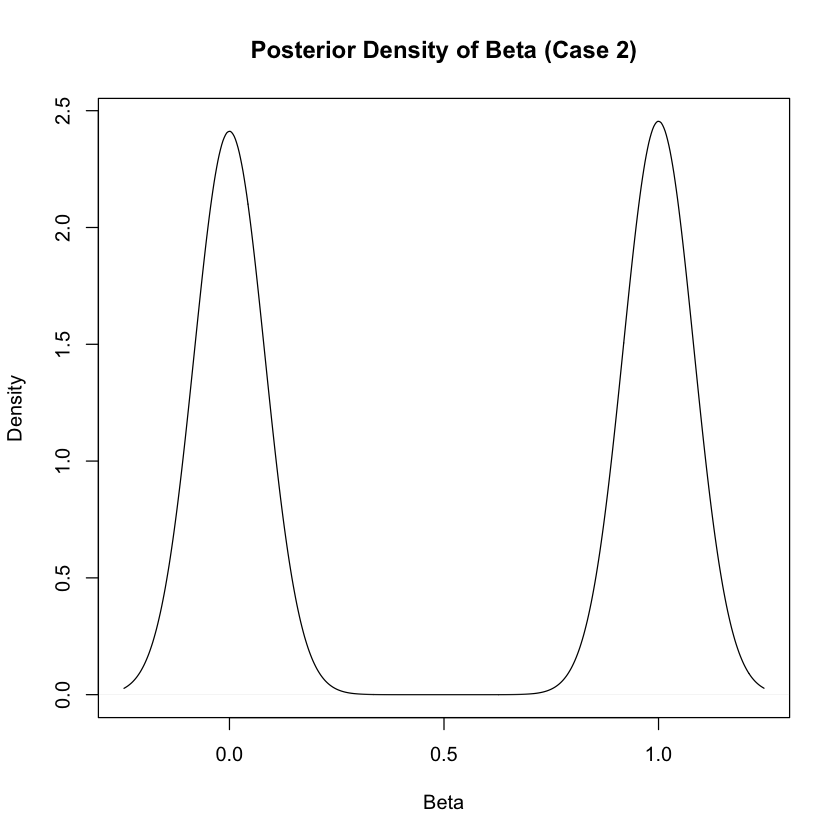

In [50]:
dens_plot_case2_sigma20 <- density(samples_case2$sigma20)
plot(dens_plot_case2_sigma20,main = "Posterior Density of Sigma20 (Case 2)", xlab = "Sigma20")
dens_plot_case2_beta <- density(samples_case2$beta)
plot(dens_plot_case2_beta, main = "Posterior Density of Beta (Case 2)", xlab = "Beta")

The plots are centered differently with the change of a.